# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#294B8E; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #294B8E">📊 Determining the age of buyers</p>

<a id="Data-description"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Data description</div>

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

Khleb-Sol chain supermarket introduces a computer vision system for processing customers' photos. Photo fixation in the checkout area will help determine the age of customers in order to:
- Analyze purchases and offer products that may be of interest to buyers of this age group;
- Control the conscientiousness of cashiers when selling alcohol.
    
<br>Build a model that will determine the approximate age of a person from a photo. At your disposal is a set of photographs of people with age indication.
</div>

<a id="Exploratory-data-analysis"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Exploratory data analysis</div>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt 
import pandas as pd

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


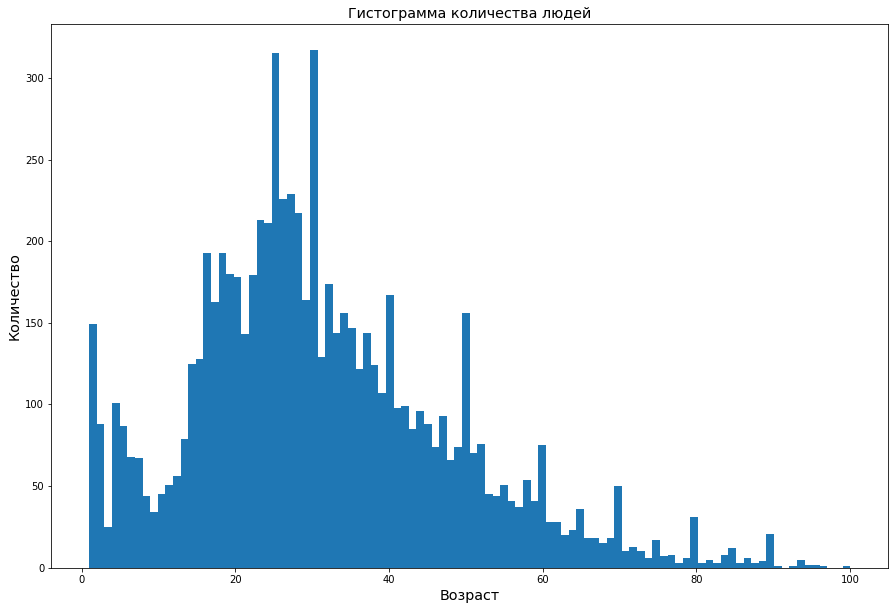

In [5]:
plt.figure(figsize=(15,10))
labels['real_age'].plot.hist(bins=100)
plt.title('Histogram of the number of people', fontsize='x-large')
plt.xlabel('Age', fontsize='x-large')
plt.ylabel('Amount', fontsize='x-large');

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
%%time
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.
CPU times: user 441 ms, sys: 428 ms, total: 868 ms
Wall time: 1min 28s


In [8]:
# sample size
total_sample=train_gen_flow.n
total_sample

7591

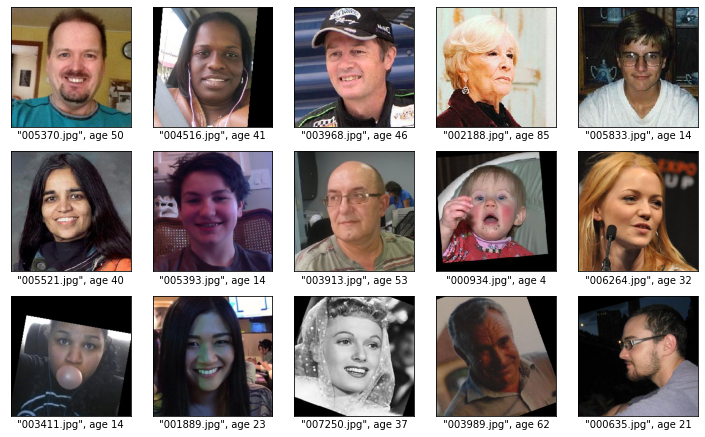

In [11]:
# print 15 photos
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1) 
    plt.imshow(train_gen_flow[0][0][i]) 
    plt.xlabel(
        f'"{train_gen_flow.filenames[train_gen_flow.index_array[i]]}", age {train_gen_flow[0][1][i]}'
    )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [1]:
plt.figure(figsize=(15,3))
plt.title('Age range chart', fontsize='x-large')
plt.boxplot(labels['real_age'], vert=False)
plt.xlabel('Age', fontsize='x-large')
plt.show()

NameError: name 'plt' is not defined

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>✍ Conclusion</b>
     <ul>
<li>The age distribution in the sample has been constructed. 7591 records were found in the dataset. Not too much, but let's try to apply the ResNet architecture.</li>
<li>No gaps found. </li>
<li>15 photos printed. </li>
<li>Photos differ in quality, photos with different rotation angles and different scales are visible. To eliminate these differences, you can apply augmentation (reflection, rotations, shifts).</li>
<li>You can see from the age range diagram that there are few outliers, but this can also distort the model a little.</li>
<li>Most people are between 20 and 40.</li>
<li>The average age of people in the dataset is 29 years old. </li>
</ul>
Train the model on more training cycles
Get rid of errors in face detection in dataset images
   
</div>

<a id="Model-Training"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Model Training</div>

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import pandas as pd
import numpy as np

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345) 

    return train_gen_flow
def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator( validation_split=0.2, rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='validation',
          seed=12345) 

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model
def train_model(
    model,
    train_datagen_flow,
    test_data_flow,
    batch_size=None,
    epochs=5,
    steps_per_epoch=None,
    validation_steps=None
    ):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_data_flow) 

    model.fit_generator(
      train_datagen_flow,
      validation_data=test_data_flow,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2,
      shuffle=True
  )

    return model

 

 

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-05-15 09:21:54.309981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-15 09:21:56.556789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 65s - loss: 265.8754 - mae: 11.4936 - val_loss: 835.5573 - val_mae: 23.8710
Epoch 2/5
190/190 - 37s - loss: 61.8655 - mae: 5.9426 - val_loss: 773.5418 - val_mae: 22.6996
Epoch 3/5
190/190 - 37s - loss: 29.9342 - mae: 4.2494 - val_loss: 235.2903 - val_mae: 11.2655
Epoch 4/5
190/190 - 37s - loss: 20.9246 - mae: 3.5452 - val_loss: 101.9401 - val_mae: 7.6240
Epoch 5/5
190/190 - 37s - loss: 16.1282 - mae: 3.0999 - val_loss: 75.3576 - val_mae: 6.6970
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 75.3576 - mae: 6.6970
Test MAE: 6.6970




```

<a id="Analysis-of-the-trained-model"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Analysis of the trained model</div>

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">
<b>✍ Conclusion</b>
<br>The distribution of age in the sample is constructed. 7591 records were found in the dataset. Not too much, but we tried to apply the ResNet architecture.
<br>No passes found.
<br>15 photos printed.
<br>Photos differ in quality, photos with different rotation angles and different scales are visible. To eliminate these differences, you can apply augmentation (reflection, rotations, shifts).
<br>Most people are between the ages of 20 and 40.
<br>It can be seen from the age range diagram that there are few outliers, but this can also slightly distort the model.
<br>The average age of people in the dataset is 29 years.
<br>When training the model, the ResNet architecture was used, pre-trained on the ImageNet dataset with GlobalAveragePooling2D layers - pooling with a window to the entire tensor and Dense - a fully connected layer for classification.
<br>ReLU activation function applied.
<br>We used the MAE quality metric, no more than 8.



</div>